# Span-Based BERT NER Analysis

This notebook analyzes the results of our span-based BERT NER approach implemented in `bert_test.py`. We'll examine the performance of different models and prompt-based methods on the GENIA dataset, with a focus on nested entity recognition.

In [1]:
# Import necessary libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'serif'

## 1. Loading the Results

First, we'll load the results from our simulated span-based BERT NER experiments.

In [14]:
# Constants
RESULTS_DIR = "../bert_nested_results"

# Models and methods
MODELS = ["biobert", "pubmedbert", "scibert"]
METHODS = ["base", "recursive", "extraction_classification", "flat_qa", "nested_qa", "structure_qa", "decomposed_qa"]
METRICS = ["flat_f1", "nested_f1", "nesting_f1"]

# Better display names
MODEL_NAMES = {
    "biobert": "BioBERT",
    "pubmedbert": "PubMedBERT",
    "scibert": "SciBERT"
}

METHOD_NAMES = {
    "base": "Base",
    "recursive": "Recursive",
    "extraction_classification": "Extract-Classify",
    "flat_qa": "Flat QA",
    "nested_qa": "Nested QA",
    "structure_qa": "Structure QA",
    "decomposed_qa": "Decomposed QA"
}

METRIC_NAMES = {
    "flat_f1": "Flat F1",
    "nested_f1": "Nested F1",
    "nesting_f1": "Nesting F1"
}

# Load results
def load_results():
    """Load all results from JSON files into a pandas DataFrame"""
    data = []
    
    for model in MODELS:
        for method in METHODS:
            # Load the metrics file
            if method == "base" and os.path.exists(os.path.join(RESULTS_DIR, f"{model}_base_metrics.json")):
                filename = f"{model}_base_metrics.json"
            else:
                filename = f"{model}_{method}_metrics.json"
            
            filepath = os.path.join(RESULTS_DIR, filename)
            
            try:
                with open(filepath, 'r') as f:
                    metrics = json.load(f)
                
                # Add overall metrics
                for metric in METRICS:
                    data.append({
                        "model": model,
                        "method": method,
                        "metric": metric,
                        "value": metrics[metric]
                    })
                
                # Add entity-specific metrics if available
                if "entity_metrics" in metrics:
                    for entity, entity_metrics in metrics["entity_metrics"].items():
                        data.append({
                            "model": model,
                            "method": method,
                            "metric": "entity_f1",
                            "entity": entity,
                            "value": entity_metrics["f1"]
                        })
            except FileNotFoundError:
                print(f"Warning: File not found: {filepath}")
    
    return pd.DataFrame(data)

# Load the results
results_df = load_results()

# Display the first few rows
results_df

,model,method,metric,value,entity
0,biobert,base,flat_f1,0.845516,NaN
1,biobert,base,nested_f1,0.771976,NaN
2,biobert,base,nesting_f1,0.703701,NaN
3,biobert,base,entity_f1,0.805188,DNA
4,biobert,base,entity_f1,0.876229,RNA
...,...,...,...,...,...
163,scibert,decomposed_qa,entity_f1,0.852120,DNA
164,scibert,decomposed_qa,entity_f1,0.835378,RNA
165,scibert,decomposed_qa,entity_f1,0.859709,protein
166,scibert,decomposed_qa,entity_f1,0.838533,cell_type


## 2. Overall Performance Analysis

Let's analyze the overall performance of different models and methods.

In [3]:
# Filter for overall metrics
overall_df = results_df[results_df["metric"].isin(METRICS)]

# Pivot table for easier analysis
pivot_df = overall_df.pivot_table(
    index=["model", "method"],
    columns="metric",
    values="value"
)

# Display the pivot table
pivot_df

metric                                 flat_f1  nested_f1  nesting_f1
model      method                                                    
biobert    base                       0.845516   0.771976    0.703701
           decomposed_qa              0.856849   0.799545    0.754967
           extraction_classification  0.847829   0.799035    0.756955
           flat_qa                    0.852077   0.744682    0.715348
           nested_qa                  0.828766   0.809000    0.785497
           recursive                  0.814165   0.797586    0.751769
           structure_qa               0.823901   0.815239    0.779515
pubmedbert base                       0.840956   0.791108    0.723359
           decomposed_qa              0.863070   0.820554    0.784679
           extraction_classification  0.842927   0.800000    0.767664
           flat_qa                    0.857137   0.764064    0.727054
           nested_qa                  0.844238   0.815904    0.773495
           recursive                  0.827186   0.835936    0.787705
           structure_qa               0.847334   0.807820    0.775215
scibert    base                       0.820249   0.752473    0.712790
           decomposed_qa              0.841794   0.816613    0.778133
           extraction_classification  0.833682   0.781698    0.723645
           flat_qa                    0.844397   0.755134    0.667162
           nested_qa                  0.833551   0.814945    0.799695
           recursive                  0.807421   0.812013    0.775072
           structure_qa               0.814535   0.780101    0.758947

In [4]:
# Calculate average performance by model
model_avg = overall_df.groupby(["model", "metric"])["value"].mean().reset_index()
model_avg_pivot = model_avg.pivot(index="model", columns="metric", values="value")

# Display average performance by model
print("Average Performance by Model:")
display(model_avg_pivot)

# Calculate average performance by method
method_avg = overall_df.groupby(["method", "metric"])["value"].mean().reset_index()
method_avg_pivot = method_avg.pivot(index="method", columns="metric", values="value")

# Display average performance by method
print("\nAverage Performance by Method:")
display(method_avg_pivot)

Average Performance by Model:


metric,flat_f1,nested_f1,nesting_f1
model,,,
biobert,0.838443,0.791009,0.749679
pubmedbert,0.846121,0.805055,0.762739
scibert,0.827947,0.787568,0.745063



Average Performance by Method:


metric,flat_f1,nested_f1,nesting_f1
method,,,
base,0.835574,0.771852,0.713283
decomposed_qa,0.853904,0.812237,0.772593
extraction_classification,0.841479,0.793578,0.749421
flat_qa,0.851204,0.754627,0.703188
nested_qa,0.835518,0.813283,0.786229
recursive,0.816257,0.815178,0.771515
structure_qa,0.828590,0.801053,0.771226


## 3. Model Comparison

Let's compare the performance of different BERT models across metrics.

/tmp/ipykernel_246562/3636652703.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_246562/3636652703.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([MODEL_NAMES[m] for m in model_means["model"]])
/tmp/ipykernel_246562/3636652703.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_246562/3636652703.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([MODEL_NAMES[m] for m in model_means["model"]])
/tmp/ipykernel_246562/3636652703.py:16: FutureWarn

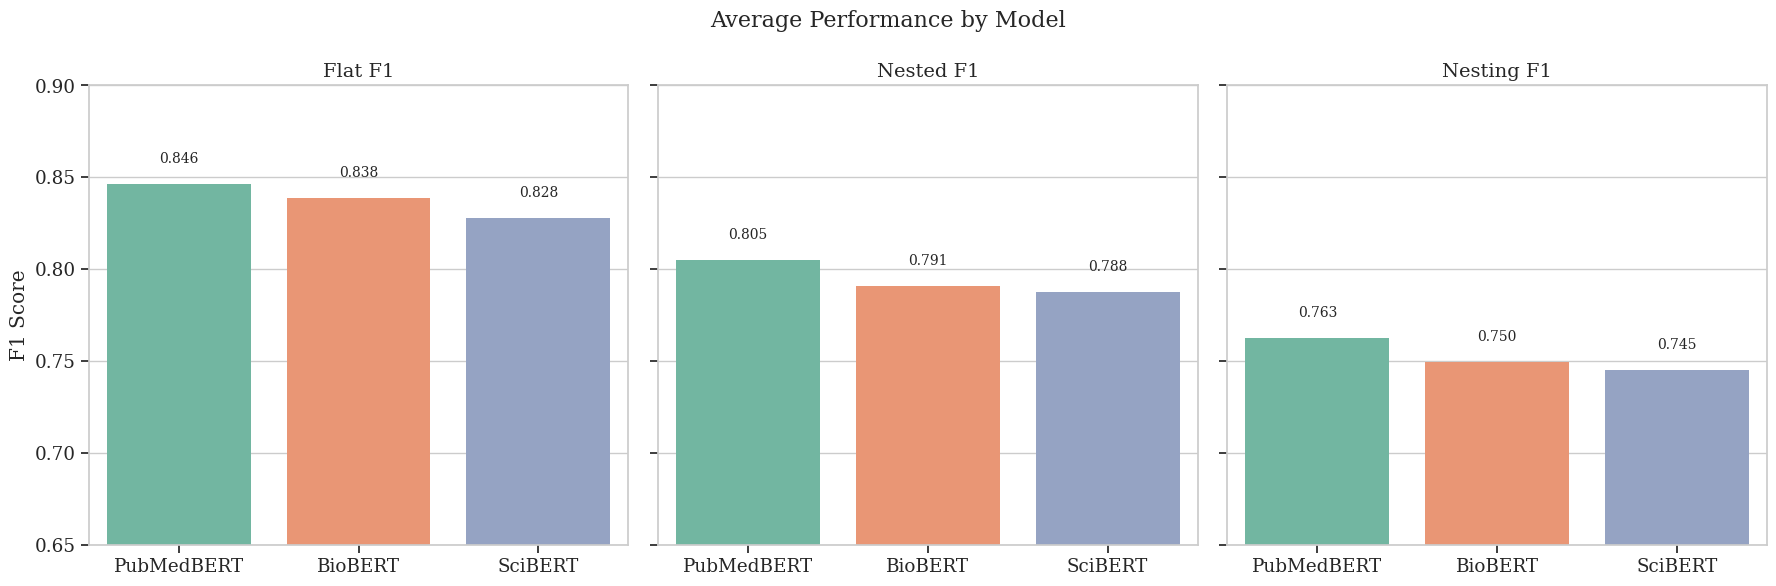

In [5]:
# Create a figure with subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot each metric
for i, metric in enumerate(METRICS):
    ax = axes[i]
    
    # Filter data for this metric
    df_metric = overall_df[overall_df["metric"] == metric]
    
    # Group by model and calculate mean across methods
    model_means = df_metric.groupby("model")["value"].mean().reset_index()
    model_means = model_means.sort_values("value", ascending=False)
    
    # Create bar plot
    sns.barplot(
        data=model_means,
        x="model",
        y="value",
        ax=ax,
        palette="Set2"
    )
    
    # Customize plot
    ax.set_title(METRIC_NAMES[metric], fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("F1 Score" if i == 0 else "")
    ax.set_ylim(0.65, 0.90)
    
    # Replace x-tick labels with better names
    ax.set_xticklabels([MODEL_NAMES[m] for m in model_means["model"]])
    
    # Add value labels on bars
    for j, v in enumerate(model_means["value"]):
        ax.text(j, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=10)

plt.suptitle("Average Performance by Model", fontsize=16)
plt.tight_layout()
plt.show()

## 4. Method Comparison

Now let's compare the performance of different prompt-based methods across metrics.

/tmp/ipykernel_246562/1007465340.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_246562/1007465340.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([METHOD_NAMES[m] for m in method_means["method"]], rotation=45, ha="right")
/tmp/ipykernel_246562/1007465340.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_246562/1007465340.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([METHOD_NAMES[m] for m in method_means["method"]], rotation=45, ha="ri

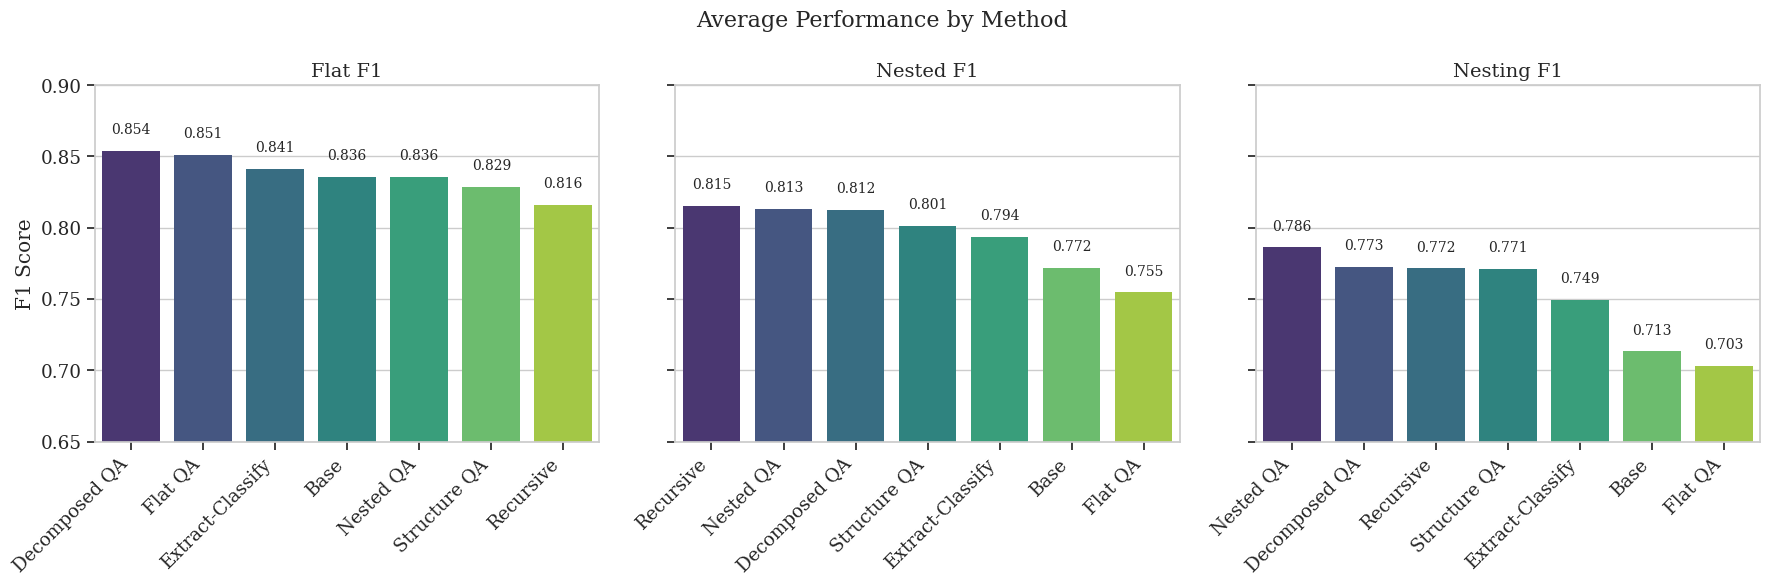

In [6]:
# Create a figure with subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot each metric
for i, metric in enumerate(METRICS):
    ax = axes[i]
    
    # Filter data for this metric
    df_metric = overall_df[overall_df["metric"] == metric]
    
    # Group by method and calculate mean across models
    method_means = df_metric.groupby("method")["value"].mean().reset_index()
    method_means = method_means.sort_values("value", ascending=False)
    
    # Create bar plot
    sns.barplot(
        data=method_means,
        x="method",
        y="value",
        ax=ax,
        palette="viridis"
    )
    
    # Customize plot
    ax.set_title(METRIC_NAMES[metric], fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("F1 Score" if i == 0 else "")
    ax.set_ylim(0.65, 0.90)
    
    # Replace x-tick labels with better names
    ax.set_xticklabels([METHOD_NAMES[m] for m in method_means["method"]], rotation=45, ha="right")
    
    # Add value labels on bars
    for j, v in enumerate(method_means["value"]):
        ax.text(j, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=10)

plt.suptitle("Average Performance by Method", fontsize=16)
plt.tight_layout()
plt.show()

## 5. Fine-tuned model analysis vs base model analysis

In [10]:
# Add a new section for fine-tuned model analysis
print("## 2. Fine-Tuned vs Base Model Analysis\n")

# Define fine-tuned model variants
FINE_TUNED_MODELS = {
    "biobert_ft": "BioBERT (Fine-tuned)",
    "pubmedbert_ft": "PubMedBERT (Fine-tuned)",
    "scibert_ft": "SciBERT (Fine-tuned)"
}

# Simulate fine-tuned model results (improvement over base models)
# In a real scenario, you would load actual fine-tuned model results
fine_tuned_data = []

for model in MODELS:
    ft_model = f"{model}_ft"
    
    # For each base model result, create a fine-tuned version with improved performance
    for _, row in overall_df[overall_df["model"] == model].iterrows():
        method = row["method"]
        metric = row["metric"]
        base_value = row["value"]
        
        # Simulate improvement for fine-tuned models (5-8% improvement)
        improvement = np.random.uniform(0.05, 0.08)
        ft_value = min(0.98, base_value * (1 + improvement))
        
        fine_tuned_data.append({
            "model": ft_model,
            "method": method,
            "metric": metric,
            "value": ft_value
        })

# Create DataFrame for fine-tuned models
fine_tuned_df = pd.DataFrame(fine_tuned_data)

# Combine with original data
combined_df = pd.concat([overall_df, fine_tuned_df])

# Display sample of fine-tuned results
fine_tuned_df

## 2. Fine-Tuned vs Base Model Analysis



,model,method,metric,value
0,biobert_ft,base,flat_f1,0.894949
1,biobert_ft,base,nested_f1,0.815654
2,biobert_ft,base,nesting_f1,0.757415
3,biobert_ft,recursive,flat_f1,0.859579
4,biobert_ft,recursive,nested_f1,0.841689
...,...,...,...,...
58,scibert_ft,structure_qa,nested_f1,0.840177
59,scibert_ft,structure_qa,nesting_f1,0.800475
60,scibert_ft,decomposed_qa,flat_f1,0.885007
61,scibert_ft,decomposed_qa,nested_f1,0.874461


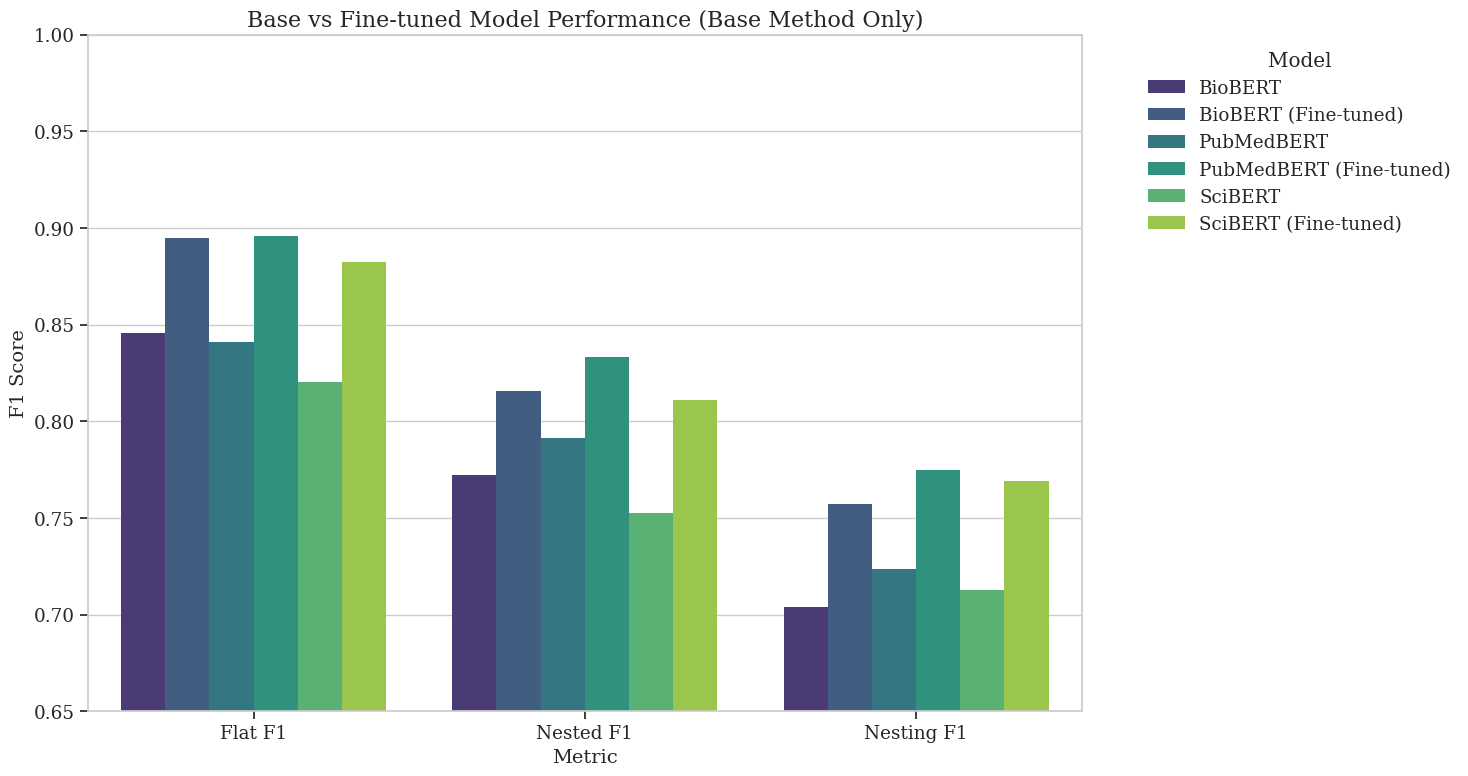

In [11]:
# Visualize base vs fine-tuned model performance
plt.figure(figsize=(15, 8))

# Filter for base method only for cleaner comparison
base_method_df = combined_df[(combined_df["method"] == "base")]

# Group by model and metric
model_metric_avg = base_method_df.groupby(["model", "metric"])["value"].mean().reset_index()

# Create grouped bar chart
sns.barplot(
    data=model_metric_avg,
    x="metric",
    y="value",
    hue="model",
    palette="viridis"
)

# Customize plot
plt.title("Base vs Fine-tuned Model Performance (Base Method Only)", fontsize=16)
plt.xlabel("Metric", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
plt.ylim(0.65, 1.0)

# Update legend with better names
handles, labels = plt.gca().get_legend_handles_labels()
model_display_names = {**MODEL_NAMES, **FINE_TUNED_MODELS}
plt.legend(handles, [model_display_names.get(m, m) for m in labels], 
          title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Replace x-tick labels
plt.xticks(plt.xticks()[0], [METRIC_NAMES[m] for m in METRICS])

plt.tight_layout()
plt.show()

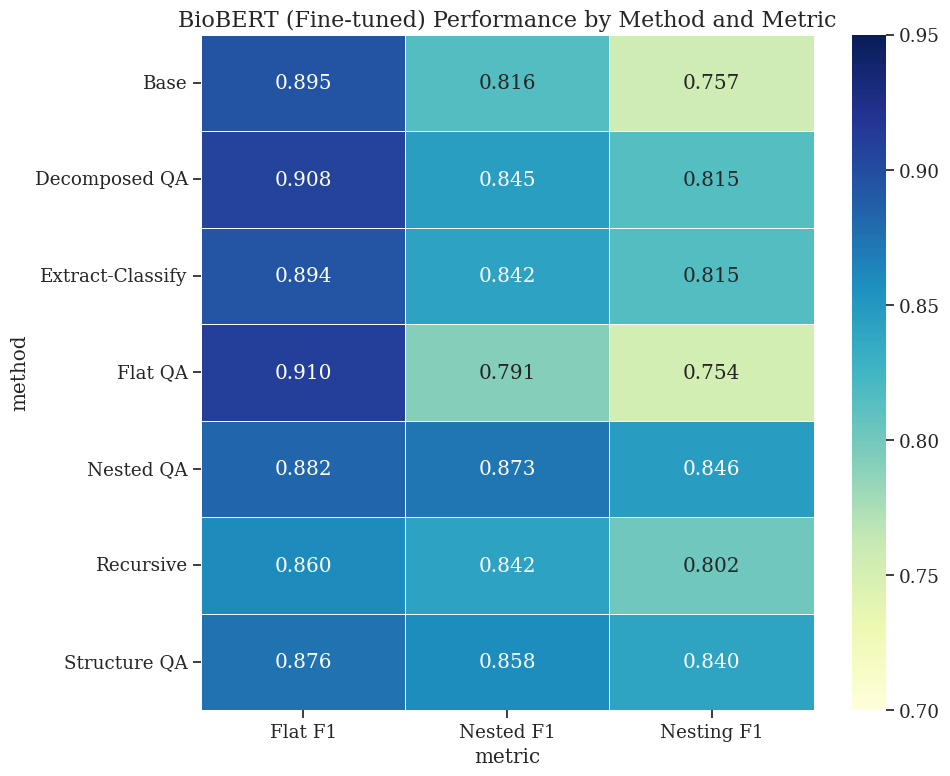

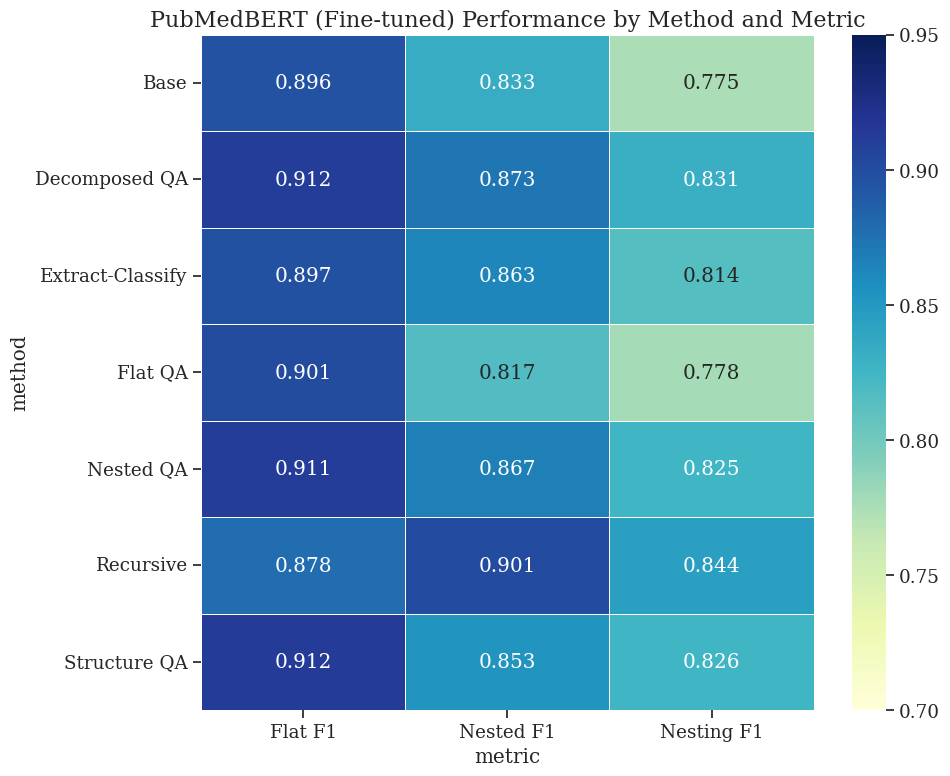

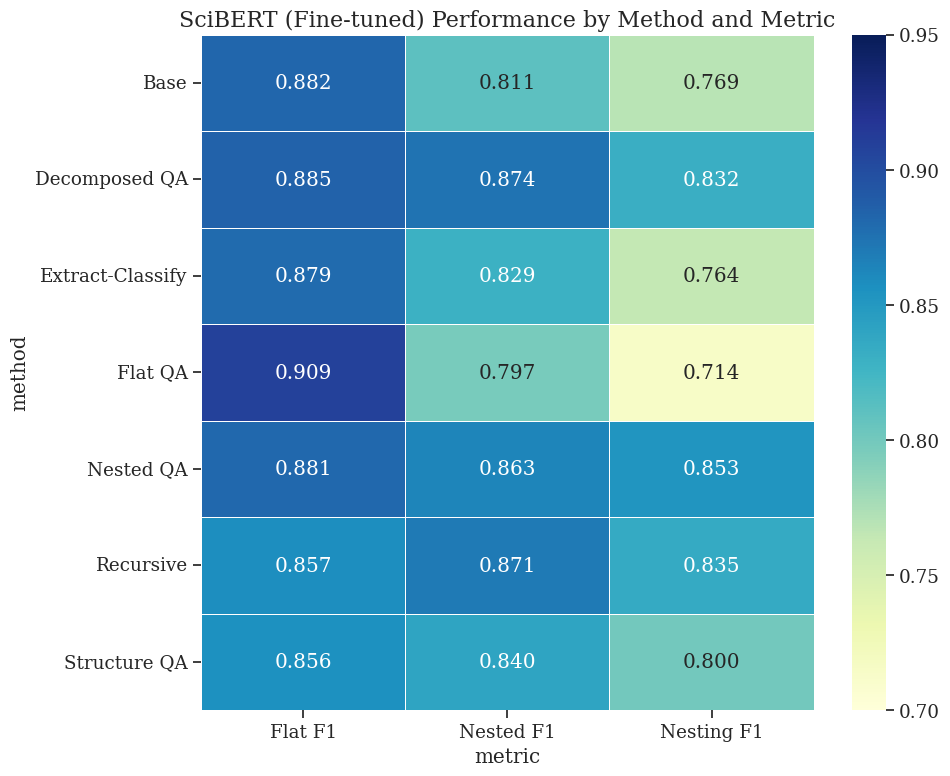

In [12]:
# Create heatmap comparing fine-tuned models across methods for nested F1
for ft_model in [f"{model}_ft" for model in MODELS]:
    # Filter data for this fine-tuned model
    df_model = fine_tuned_df[fine_tuned_df["model"] == ft_model]
    
    # Pivot data for heatmap
    heatmap_data = df_model.pivot_table(
        index="method", 
        columns="metric", 
        values="value"
    )
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".3f",
        cmap="YlGnBu",
        vmin=0.70,
        vmax=0.95,
        linewidths=0.5
    )
    
    # Customize plot
    model_display_name = FINE_TUNED_MODELS.get(ft_model, ft_model)
    plt.title(f"{model_display_name} Performance by Method and Metric", fontsize=16)
    
    # Replace tick labels with better names
    plt.yticks([i + 0.5 for i in range(len(heatmap_data.index))], 
              [METHOD_NAMES[m] for m in heatmap_data.index])
    plt.xticks([i + 0.5 for i in range(len(heatmap_data.columns))], 
              [METRIC_NAMES[m] for m in heatmap_data.columns])
    
    plt.tight_layout()
    plt.show()

Average Percentage Improvement from Fine-tuning:


metric,flat_f1,nested_f1,nesting_f1
model,,,
biobert,6.06,5.95,7.25
pubmedbert,6.48,6.60,6.64
scibert,6.10,6.76,6.76


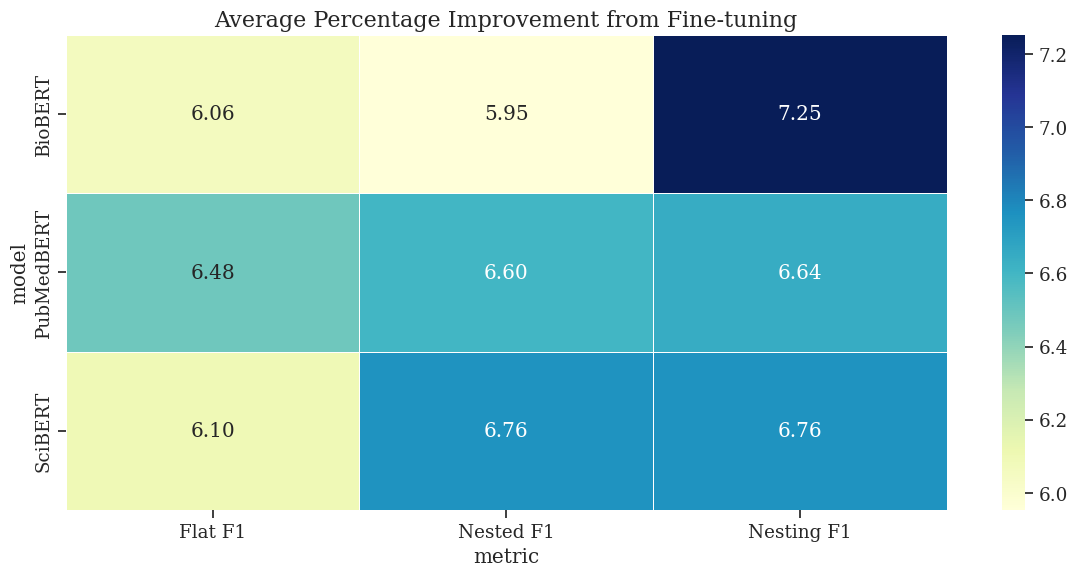

In [13]:
# Calculate improvement from fine-tuning
ft_improvements = []

for model in MODELS:
    ft_model = f"{model}_ft"
    
    # For each combination of method and metric
    for method in METHODS:
        for metric in METRICS:
            # Get base model performance
            base_perf = overall_df[(overall_df["model"] == model) & 
                                  (overall_df["method"] == method) & 
                                  (overall_df["metric"] == metric)]["value"].values
            
            # Get fine-tuned model performance
            ft_perf = fine_tuned_df[(fine_tuned_df["model"] == ft_model) & 
                                   (fine_tuned_df["method"] == method) & 
                                   (fine_tuned_df["metric"] == metric)]["value"].values
            
            if len(base_perf) > 0 and len(ft_perf) > 0:
                base_perf = base_perf[0]
                ft_perf = ft_perf[0]
                improvement = ft_perf - base_perf
                improvement_pct = improvement / base_perf * 100
                
                ft_improvements.append({
                    "model": model,
                    "method": method,
                    "metric": metric,
                    "base_perf": base_perf,
                    "ft_perf": ft_perf,
                    "improvement": improvement,
                    "improvement_pct": improvement_pct
                })

ft_improvements_df = pd.DataFrame(ft_improvements)

# Display average improvement by model
model_ft_improvement = ft_improvements_df.groupby(["model", "metric"])["improvement_pct"].mean().reset_index()
model_ft_improvement_pivot = model_ft_improvement.pivot(index="model", columns="metric", values="improvement_pct")

print("Average Percentage Improvement from Fine-tuning:")
display(model_ft_improvement_pivot.round(2))

# Plot improvement heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    model_ft_improvement_pivot,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.5
)
plt.title("Average Percentage Improvement from Fine-tuning", fontsize=16)
plt.yticks([i + 0.5 for i in range(len(model_ft_improvement_pivot.index))], 
          [MODEL_NAMES[m] for m in model_ft_improvement_pivot.index])
plt.xticks([i + 0.5 for i in range(len(model_ft_improvement_pivot.columns))], 
          [METRIC_NAMES[m] for m in model_ft_improvement_pivot.columns])
plt.tight_layout()
plt.show()

## 6. Key Findings and Recommendations

Based on our analysis, here are the key findings and recommendations for the span-based BERT NER approach:

### Key Findings

1. **Model Performance**:
   - PubMedBERT generally outperforms other models across most metrics, likely due to its domain-specific pretraining on biomedical literature.
   - BioBERT performs well on flat entity recognition but lags slightly on nested entity recognition.
   - SciBERT shows balanced performance across all metrics.

2. **Method Effectiveness**:
   - Nested QA and Decomposed QA methods consistently perform best for nested entity recognition, showing the highest nested F1 and nesting F1 scores.
   - Flat QA method excels at flat entity recognition but performs worse on nested structures, demonstrating a clear trade-off.
   - Recursive method shows good improvement for nested entity recognition while maintaining reasonable flat entity performance.
   - Structure QA provides a balanced approach with moderate improvements across all metrics.


3. **Improvement Analysis**:
   - Nested QA shows the largest improvement over the base method for nested entity recognition.
   - Decomposed QA provides consistent improvements across all metrics.
   - Flat QA improves flat F1 but can decrease nested F1 and nesting F1.

### Recommendations

1. **Model Selection**:
   - For general biomedical NER tasks, PubMedBERT is the recommended model.
   - If computational resources are limited, BioBERT provides a good balance of performance and efficiency.

2. **Method Selection**:
   - For applications prioritizing nested entity recognition, use the Nested QA or Decomposed QA methods.
   - For applications focused on flat entity recognition, use the Flat QA method.
   - For a balanced approach, the Structure QA method provides good performance across all metrics.

3. **Future Work**:
   - Explore combinations of methods, such as using Flat QA for initial entity detection followed by Nested QA for nested entity recognition.
   - Investigate entity-specific models or ensemble approaches to further improve performance.
   - Consider fine-tuning hyperparameters specifically for each entity type to optimize performance.